In [1]:
import sympy as sm
from sympy import diff, Symbol
from scipy.integrate import odeint
import numpy as np
from sympy.physics.mechanics import dynamicsymbols
import math

In [2]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [3]:
theta, r = dynamicsymbols('theta r')
thetad = dynamicsymbols('theta',1)
thetadd = dynamicsymbols('theta',2)
rd = dynamicsymbols('r',1)
rdd = dynamicsymbols('r',2)
theta,r,thetad, thetadd, rd, rdd

(theta, r, theta', theta'', r', r'')

In [4]:
m=1
g=9.81

In [5]:
x = r*sm.cos(theta)
y = r*sm.sin(theta)
x,y

(r*cos(theta), r*sin(theta))

In [6]:
xd = sm.diff(x,'t')
yd = sm.diff(y,'t')
xd,yd

(-r*sin(theta)*theta' + cos(theta)*r', r*cos(theta)*theta' + sin(theta)*r')

In [7]:
xdd = sm.diff(xd,'t')
ydd = sm.diff(yd,'t')
xdd, ydd

(-r*sin(theta)*theta'' - r*cos(theta)*theta'**2 - 2*sin(theta)*r'*theta' + cos(theta)*r'', -r*sin(theta)*theta'**2 + r*cos(theta)*theta'' + sin(theta)*r'' + 2*cos(theta)*r'*theta')

In [8]:
dynamics_sol = sm.solve([(m*xdd)  ,((m*ydd)+(m*g)) ],[rdd,thetadd])
rdd_solver = sm.simplify(dynamics_sol[rdd])
thetadd_solver = sm.simplify(dynamics_sol[thetadd])
rdd_solver,thetadd_solver

(1.0*r*theta'**2 - 9.81*sin(theta), -(9.81*cos(theta) + 2.0*r'*theta')/r)

In [9]:
M = sm.Matrix([[m, 0],[0, m]])
M

Matrix([
[1, 0],
[0, 1]])

In [10]:
a0 = sm.Matrix([rdd_solver, thetadd_solver])
a0

Matrix([
[   1.0*r*theta'**2 - 9.81*sin(theta)],
[-(9.81*cos(theta) + 2.0*r'*theta')/r]])

In [11]:
F = m*a0
F

Matrix([
[   1.0*r*theta'**2 - 9.81*sin(theta)],
[-(9.81*cos(theta) + 2.0*r'*theta')/r]])

<h3>constraint is described by</h3>

In [12]:
r_c = sm.exp(0.1*theta)
theta_c = -Symbol('t')+30
r_c,theta_c

(exp(0.1*theta), 30 - t)

In [13]:
r_cdd = sm.diff(sm.diff(r_c,'t'),'t')
theta_cdd = sm.diff(sm.diff(theta_c,'t'),'t')
r_cdd, theta_cdd

(0.01*exp(0.1*theta)*theta'**2 + 0.1*exp(0.1*theta)*theta'', 0)

In [14]:
r_ac = rdd - r_cdd
theta_ac = thetadd - theta_cdd
r_ac,theta_ac

(-0.01*exp(0.1*theta)*theta'**2 - 0.1*exp(0.1*theta)*theta'' + r'', theta'')

In [15]:
rs1 = r_ac.coeff(rdd)
thetas1 = r_ac.coeff(thetadd)
rs2 = theta_ac.coeff(rdd)
thetas2 = theta_ac.coeff(thetadd)
A = sm.Matrix([[rs1,thetas1],[rs2,thetas2]])
A

Matrix([
[1, -0.1*exp(0.1*theta)],
[0,                   1]])

In [16]:
b1 = -(r_ac - rs1*rdd - thetas1*thetadd)
b2 = -(theta_ac - rs2*rdd - thetas2*thetadd)
b = sm.Matrix([b1 , b2])
b

Matrix([
[0.01*exp(0.1*theta)*theta'**2],
[                            0]])

In [17]:
Fc =  M**(1/2)*sm.Matrix.pinv(A*(M**(-1/2)))*(b-(A*(M**(-1))*F))
Fc

Matrix([
[-1.0*r*theta'**2 + 0.01*exp(0.1*theta)*theta'**2 + 9.81*sin(theta)],
[                               (9.81*cos(theta) + 2.0*r'*theta')/r]])

In [18]:
rf = F + Fc
rf

Matrix([
[0.01*exp(0.1*theta)*theta'**2],
[                            0]])

In [19]:
F

Matrix([
[   1.0*r*theta'**2 - 9.81*sin(theta)],
[-(9.81*cos(theta) + 2.0*r'*theta')/r]])

In [20]:
rdd_func = sm.lambdify([theta, thetad, r, rd], rf[0])
thetadd_func = sm.lambdify([theta, thetad, r, rd], rf[1])
rd_func = sm.lambdify(rd, rd)
thetad_func = sm.lambdify(thetad, thetad)

Q_func = sm.lambdify([theta, thetad, r, rd], F)
Qc_func = sm.lambdify([theta, thetad, r, rd], Fc)

pinv_func = sm.lambdify([theta, thetad, r, rd], sm.Matrix.pinv(A*(M**(-1/2))))
A_func = sm.lambdify([theta, thetad, r, rd], A)
b_func = sm.lambdify([theta, thetad, r, rd], b)
_AMQ_func = sm.lambdify([theta, thetad, r, rd], A*(M**(-1))*F )
B_func = sm.lambdify([theta, thetad, r, rd],(b-(A*(M**(-1))*F)))

In [78]:
# ode func for scipy odeint
def dSdt(S,t):
    thetv, thetvd ,rv, rvd = S
    print(S, t)
    print(type(thetv) , type(thetvd), type(rv), type(rvd))
    Q = Q_func(thetv, thetvd, rv, rvd)
    Qc = Qc_func(thetv, thetvd, rv, rvd)
    #print(f" Q: {Q}")
    #print(f" Qc: {Qc}")
    
    print(f" q0 : {thetad_func(thetvd)}")
    print(f" qq0 :{thetadd_func(thetv, thetvd, rv, rvd)}")
    print(f" q1 :{rd_func(rvd)}")
    print(f" qq1 :{rdd_func(thetv, thetvd, rv, rvd)}")
    print("\n\n")
    return [
        thetad_func(thetvd),
        thetadd_func(thetv, thetvd, rv, rvd)/m,
        rd_func(rvd),
        rdd_func(thetv, thetvd, rv, rvd)/m
    ]

In [79]:
t = np.linspace(0, 50, 251)
r_ic = math.exp(3)
theta_ic = 30
r_d_ic = -0.1*math.exp(3)
theta_d_ic = -1
ans = odeint(dSdt, y0=[theta_ic,theta_d_ic,r_ic,r_d_ic], t=t)

[30.         -1.         20.08553692 -2.00855369] 0.0
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
 q0 : -1.0
 qq0 :0
 q1 :-2.008553692318767
 qq1 :0.2008553692318767



[29.99997559 -1.         20.0854879  -2.00854879] 2.440966483826081e-05
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
 q0 : -1.0
 qq0 :0
 q1 :-2.008548789506523
 qq1 :0.2008548789512507



[29.99997559 -1.         20.0854879  -2.00854879] 2.440966483826081e-05
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
 q0 : -1.0
 qq0 :0
 q1 :-2.008548789518491
 qq1 :0.2008548789512507



[29.99995118 -1.         20.08543887 -2.00854389] 4.881932967652162e-05
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
 q0 : -1.0
 qq0 :0
 q1 :-2.0085438867182144
 qq1 :0.20085438867182143



[29.99995118 -1.         20.08543887 -2.00854389] 4.88193296

In [80]:
ans.T

array([[ 3.00000000e+01,  2.98000000e+01,  2.96000000e+01, ...,
        -1.96000000e+01, -1.98000000e+01, -2.00000000e+01],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 2.00855369e+01,  1.96878167e+01,  1.92979720e+01, ...,
         1.40856879e-01,  1.38067686e-01,  1.35333722e-01],
       [-2.00855369e+00, -1.96878167e+00, -1.92979720e+00, ...,
        -1.40858902e-02, -1.38069718e-02, -1.35335764e-02]])

In [24]:
thetv_ = ans.T[0]
thetvd_ = ans.T[1]
rv_ = ans.T[2]
rvd_ = ans.T[3]

In [25]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Relation between r and θ in constrained system')

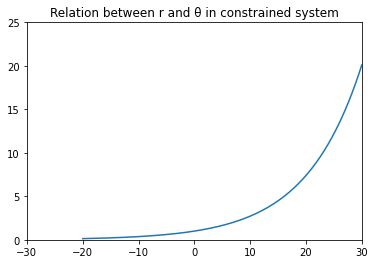

In [26]:
plt.axis([-30, 30, 0, 25])
plt.plot(thetv_, rv_)
plt.title("Relation between r and θ in constrained system")

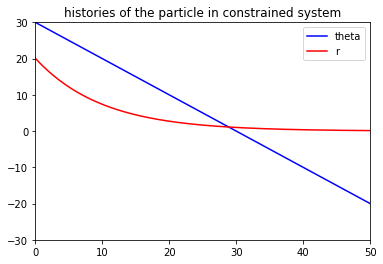

In [27]:
plt.axis([0, 50, -30, 30])
plt.plot(t, thetv_,color='b', label='theta')
plt.plot(t, rv_, color='r', label='r')
plt.title("histories of the particle in constrained system")
plt.legend()
plt.show()

In [28]:
x = r*sm.cos(theta)
y = r*sm.sin(theta)
def get_xy(the, d):
    return (d*np.cos(the),
            d*np.sin(the))


x,y = get_xy(ans.T[0],ans.T[2])

Text(0.5, 1.0, 'Relation between r and θ in constrained system')

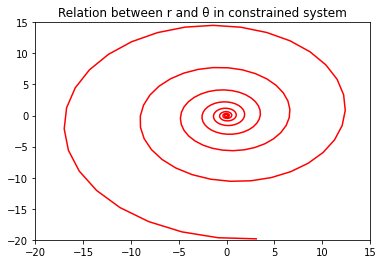

In [29]:
plt.axis([-20, 15, -20, 15])
plt.plot(x, y,color='r')
plt.title("Relation between r and θ in constrained system")